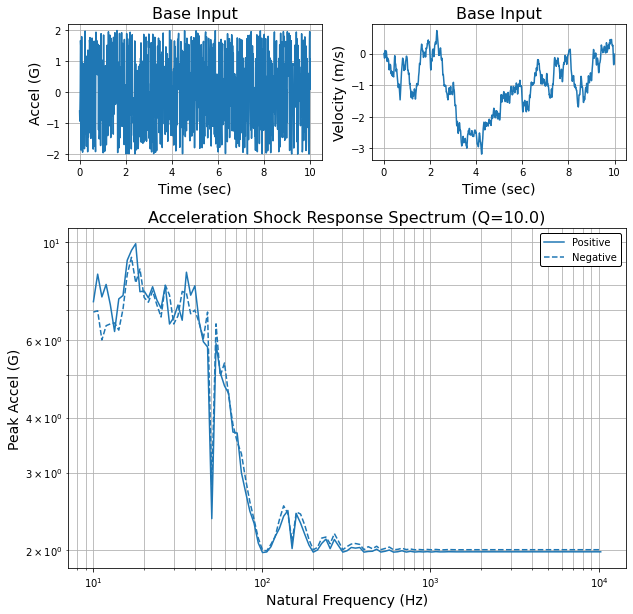

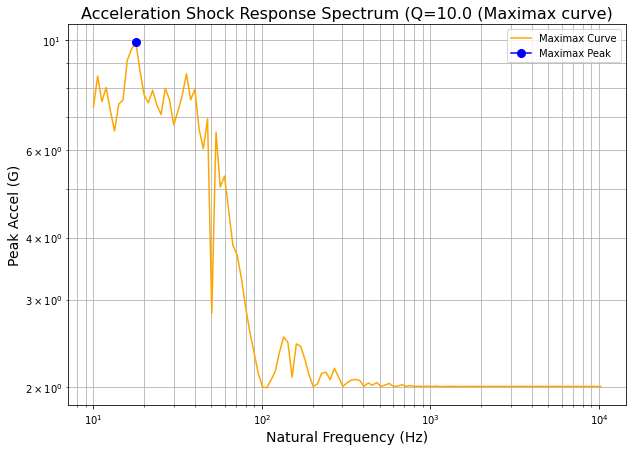

In [16]:
from scipy.signal import lfilter
from scipy import integrate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
G_TO_MPS2 = 9.81

# Plot formatting
COLORS = sns.color_palette().as_hex()
AX_LABEL_FONT_DICT = {'size': 14}
AX_TITLE_FONT_DICT = {'size': 16}

def read_tsv(path_to_tsv):
    """
    Read accelerometer data from a TSV file.
    """
    input_data = path_to_tsv
    cols = [0, 1]
    col_names = ['time_s', 'accel_g']
    input_df = pd.read_csv(input_data,
                           sep='\t',
                           header=None,
                           names=col_names,
                           usecols=cols)
    return read_dataframe(input_df)

def read_csv(path_to_csv):
    """
    Read accelerometer data from a CSV file.
    """
    input_data = path_to_csv
    cols = [0, 1]
    col_names = ['time_s', 'accel_g']
    input_df = pd.read_csv(input_data,
                           header=None,
                           names=col_names,
                           usecols=cols)
    return read_dataframe(input_df)

def read_dataframe(input_df):
    """
    Initialize ShockResponseSpectrum object with accelerometer data.
    """
    try:
        input_df.apply(pd.to_numeric)
    except ValueError:
        raise Exception("Input data file should not have column headers")
    srs_object = ShockResponseSpectrum(input_df)
    return srs_object

def build_nat_freq_array(fn_start=10., fn_end=1.0e4, oct_step_size=(1./12.)):
    """
    Generate an array of natural frequencies for SRS analysis.
    """
    fn_array = [fn_start]
    for i in range(int(fn_end - fn_start)):
        new_fn = (fn_start * 2.**(oct_step_size))
        fn_array.append(new_fn)
        fn_start = new_fn
        if fn_start > fn_end:
            break
    fn_array = np.array(fn_array)
    return fn_array

def remove_sensor_bias(input_accel_g):
    """
    Remove bias from accelerometer data.
    """
    input_accel_g = input_accel_g - input_accel_g.mean()
    return input_accel_g

class ShockResponseSpectrum:
    """
    Shock response spectrum analysis.
    """
    def __init__(self, input_df):
        self.input_df = input_df
        self.input_time_s = self.input_df.time_s.values
        self.input_accel_g = self.input_df.accel_g.values
        self.input_accel_mps2 = self.input_accel_g * G_TO_MPS2
        self.input_vel_mps = integrate.cumtrapz(self.input_accel_mps2,
                                                 self.input_time_s,
                                                 initial=0.)

    def run_srs_analysis(self, fn_array, Q=10, remove_bias=False):
        """
        Perform shock response spectrum analysis.
        """
        self.Q = Q
        self.fn_array = fn_array
        self.remove_bias = remove_bias

        if self.remove_bias:
            self.input_accel_g = remove_sensor_bias(self.input_accel_g)
            self.input_accel_mps2 = self.input_accel_g * G_TO_MPS2
            self.input_vel_mps = integrate.cumtrapz(self.input_accel_mps2,
                                                     self.input_time_s,
                                                     initial=0.)

        damp = 1. / (2. * self.Q)
        T = np.diff(self.input_time_s).mean()
        omega_n = 2. * np.pi * self.fn_array
        omega_d = omega_n * np.sqrt(1 - damp**2.)
        E = np.exp(-damp * omega_n * T)
        K = T * omega_d
        C = E * np.cos(K)
        S = E * np.sin(K)
        S_prime = S / K
        b0 = 1. - S_prime
        b1 = 2. * (S_prime - C)
        b2 = E**2. - S_prime
        a0 = np.ones_like(self.fn_array)
        a1 = -2. * C
        a2 = E**2.
        b = np.array([b0, b1, b2]).T
        a = np.array([a0, a1, a2]).T

        self.pos_accel = np.zeros_like(self.fn_array)
        self.neg_accel = np.zeros_like(self.fn_array)
        for i, f_n in enumerate(self.fn_array):
            output_accel_g = lfilter(b[i], a[i], self.input_accel_g)
            self.pos_accel[i] = output_accel_g.max()
            self.neg_accel[i] = np.abs(output_accel_g.min())

    def export_srs_to_csv(self, filename):
        """
        Export shock response spectra to a CSV file.
        """
        data_array = np.array([self.fn_array, self.pos_accel, self.neg_accel]).T
        cols = ['Natural Frequency (Hz)', 'Peak Positive Accel (G)', 'Peak Negative Accel (G)']
        srs_output_df = pd.DataFrame(data=data_array, columns=cols)
        srs_output_df.to_csv(filename, index=False)

    def _make_accel_subplot(self, ax):
        """
        Create subplot for input acceleration.
        """
        ax.plot(self.input_time_s, self.input_accel_g,
                label='Accel', color=COLORS[0], linestyle='-')
        ax.grid(True, which="both")
        ax.set_xlabel('Time (sec)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_ylabel('Accel (G)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_title('Base Input', fontdict=AX_TITLE_FONT_DICT)
        return ax

    def _make_vel_subplot(self, ax):
        """
        Create subplot for input velocity.
        """
        ax.plot(self.input_time_s, self.input_vel_mps,
                label='Vel', color=COLORS[0], linestyle='-')
        ax.grid(True, which="both")
        ax.set_xlabel('Time (sec)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_ylabel('Velocity (m/s)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_title('Base Input', fontdict=AX_TITLE_FONT_DICT)
        return ax

    def _make_srs_subplot(self, ax, requirement):
        """
        Create subplot for shock response spectrum.
        """
        ax.loglog(self.fn_array, self.pos_accel, label='Positive',
                  color=COLORS[0], linestyle='-')
        ax.loglog(self.fn_array, self.neg_accel, label='Negative',
                  color=COLORS[0], linestyle='--')
        if requirement is not None:
            self.protocol_fn, self.protocol_accel = requirement
            ax.loglog(self.protocol_fn, self.protocol_accel,
                      color=COLORS[3], linewidth=2, label='Requirement')

        leg = ax.legend(fancybox=True, framealpha=1, frameon=True)
        leg.get_frame().set_edgecolor('k')
        ax.grid(True, which="both")
        ax.set_xlabel('Natural Frequency (Hz)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_ylabel('Peak Accel (G)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_title('Acceleration Shock Response Spectrum (Q={0:.1f})'.format(self.Q),
                     fontdict=AX_TITLE_FONT_DICT)
        return ax

    def plot_results(self, requirement=None, filename=None):
        """
        Plot the results of the shock response spectrum analysis.
        """
        fig = plt.figure()
        gs = fig.add_gridspec(3, 4)
#         fig, ax = plt.subplots(2, 2, figsize=(12, 10))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        
        # Create Axes for Input Acceleration and Velocity
        ax0 = fig.add_subplot(gs[0, 0:2])
        ax1 = fig.add_subplot(gs[0, 2:])
        
        # Create Axis for SRS Output
        ax2 = fig.add_subplot(gs[1:, 0:])
        
        ax0 = self._make_accel_subplot(ax0)
        ax1 = self._make_vel_subplot(ax1)
        ax2 = self._make_srs_subplot(ax2, requirement)
        
        fig.set_size_inches(10, 10)
        if filename is not None:
            fig.savefig(filename, dpi=200)

    def plot_input_accel(self, filename=None):
        """
        Plot input acceleration.
        """
        fig, ax = plt.subplots()
        ax = self._make_accel_subplot(ax)
        fig.set_size_inches(10, 7)
        if filename is not None:
            fig.savefig(filename, dpi=200)

    def plot_input_vel(self, filename=None):
        """
        Plot input velocity.
        """
        fig, ax = plt.subplots()
        ax = self._make_vel_subplot(ax)
        fig.set_size_inches(10, 7)
        if filename is not None:
            fig.savefig(filename, dpi=200)

    def plot_srs(self, requirement=None, filename=None):
        """
        Plot shock response spectrum.
        """
        fig, ax = plt.subplots()
        ax = self._make_srs_subplot(ax, requirement)
        fig.set_size_inches(10, 7)
        if filename is not None:
            fig.savefig(filename, dpi=200)
    
    def plot_srs_with_peak(self, requirement=None, filename=None):
        """
        Plot shock response spectrum with Maximax curve and peak point.
        """
        fig, ax = plt.subplots()

        # Calculate Macimax curve
        maximax_curve = np.maximum(self.pos_accel, self.neg_accel)
        maximax_peak_index = np.argmax(maximax_curve)
        maximax_peak_freq = self.fn_array[maximax_peak_index]
        maximax_peak_accel = maximax_curve[maximax_peak_index]

        # Plot Macimax curve
        ax.loglog(self.fn_array, maximax_curve, color='orange', label='Maximax Curve')

        # Plot peak point of Macimax curve
        ax.plot(maximax_peak_freq, maximax_peak_accel, marker='o', color='blue', markersize=8, label='Maximax Peak')

        # Plot requirement curve if provided
        if requirement is not None:
            requirement_fn, requirement_accel = requirement
            ax.loglog(requirement_fn, requirement_accel, color='green', linewidth=2, label='Requirement')

        # Add labels and titles
        ax.legend()
        ax.grid(True, which="both")
        ax.set_xlabel('Natural Frequency (Hz)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_ylabel('Peak Accel (G)', fontdict=AX_LABEL_FONT_DICT)
        ax.set_title('Acceleration Shock Response Spectrum (Q={0:.1f}) (Maximax curve)'.format(self.Q),
                     fontdict=AX_TITLE_FONT_DICT)

        fig.set_size_inches(10, 7)

        if filename is not None:
            fig.savefig(filename, dpi=200)



# Example usage:
if __name__ == "__main__":
    # Read accelerometer data from a CSV file
    input_data = 'random_accel_data.csv'
    srs_data = read_csv(input_data)

    # Define natural frequency array
    fn_start = 10.
    fn_end = 10000.
    fn_array = build_nat_freq_array(fn_start, fn_end)

    # Run SRS analysis
    srs_data.run_srs_analysis(fn_array, Q=10, remove_bias=True)
    
    srs_data.plot_results(requirement=None, filename='srs_plot.png')
#     srs_data.plot_srs(requirement=None, filename='srs_plot_with_peak.png')
    

    # Plot results with Macimax curve and peak point
    srs_data.plot_srs_with_peak(requirement=None, filename='srs_plot_with_peak.png')


In [5]:
import numpy as np
import pandas as pd

# Number of data points
num_points = 1000

# Generate random time values (in seconds)
time_s = np.linspace(0, 10, num_points)

# Generate random acceleration values (in G's)
accel_g = np.random.uniform(-2, 2, num_points)

# Create a pandas DataFrame
random_data = pd.DataFrame({'time_s': time_s, 'accel_g': accel_g})

# Save the data to a CSV file
random_data.to_csv('random_accel_data.csv', index=False, header = None)
